In [29]:
#Let there be np.light
import numpy as np
import pylab as plt
import pickle as pkl
import csv
# import scipy.optimize, scipy.interpolate
import scipy.optimize as spop
import time

#Constructing fitter
def designfit(x_array,y_array, A):
    N = len(design) #number of variational parameters
    
    #Solving for fit parameters. 
    return np.linalg.solve( np.matmul(A.T,A) , np.matmul(A.T,y_array) )

def designfit_lstsq(x_array,y_array, A):
    N = len(design) #number of variational parameters
    
    #Solving for fit parameters. 
    return np.linalg.lstsq(A, y_array, rcond=None)[0]

# Defining functions

## Minimizer function (no weights)

In [30]:
def minimize_nw(data, P, Q, init_guess, n_it, len_y):
    'P is the design function in x, and \
     Q is the design function in y.'

    start_time = time.time()
    
    # Defining constants
    N = len(data)*len(data[0])
    z = data.flatten()
    
    # Initializing arrays and values
    y = np.empty(len(init_guess[:len_y]))
    x = np.empty(len(init_guess[len_y:]))
    y[:] = init_guess[:len_y]
    x[:] = init_guess[len_y:]
    sqerror = np.ones_like(data)
    
    counter = 0
    lsq = 1
    
    while counter < n_it or counter == 1:        
        counter += 1

        bQ = np.matmul(y,Q.T)
        M = np.matmul( np.matmul(P.T,np.diag(bQ)**2), P )
        v = np.matmul( P.T, z*bQ ) 
        x[:] = np.linalg.solve(M,v)[:]
        
        aP = np.matmul(x,P.T)
        M = np.matmul( np.matmul(Q.T,np.diag(aP)**2), Q )
        v = np.matmul( Q.T, z*aP )
        y[:] = np.linalg.solve(M,v)[:]
        
        print(counter)

    print(f'Time elapsed is {time.time()-start_time}. Iterations: {counter}.')
    return y,x  

## Minimizer function (with weights)

In [166]:
def remove_zeros(array):
    array = np.array(array).astype(float)
    shape = np.shape(array)
    flattened = array.flatten()
    
    flattened[np.argwhere(flattened == 0)] = 0.000000000001
#     flattened[np.argwhere(flattened == np.inf)] = 0.0001
    
    return flattened.reshape(shape)

def minimize(data, P, Q, init_guess, n_it, len_y):
    'P is the design function in x, and \
     Q is the design function in y.'

    start_time = time.time()
    
    # Defining constants
    N = len(data)*len(data[0])
    z = data.flatten()
    
    # Initializing arrays and values
    y = np.zeros(len(init_guess[:len_y]))
    x = np.zeros(len(init_guess[len_y:]))
    y[:] = init_guess[:len_y]
    x[:] = init_guess[len_y:]
    inv_sqerror = np.ones_like(data.flatten())
    
    counter = 0
    lsq = 1
    
    while counter < n_it or counter == 1:        
        counter += 1
        
        # Solving f(x) parameters
        bQ = np.matmul(y,Q.T)
        M = np.matmul( np.matmul(P.T,np.diag(inv_sqerror*bQ**2)), P )
        v = np.matmul( P.T, z*inv_sqerror*bQ ) 
        x[:] = np.linalg.solve(M,v)[:]
        
        # Solving g(y) parameters
        aP = np.matmul(x,P.T)
        M = np.matmul( np.matmul(Q.T,np.diag(inv_sqerror*aP**2)), Q )
        v = np.matmul( Q.T, z*inv_sqerror*aP )
        y[:] = np.linalg.solve(M,v)[:]
        
        # Updating squared error matrix; removing zeroes
        y_hat = np.matmul(design_y,y)
        x_hat = np.matmul(design_x,x)        
        inv_sqerror = 1/remove_zeros(np.abs(z - y_hat*x_hat))

        # Normalizing g(y) parameters
        y[:] = y[:]/np.max(y_hat)
        
        print(counter)

    print(f'Time elapsed is {time.time()-start_time}. Iterations: {counter}.')
    return y,x  

## Showing intermediate models

In [32]:
def remove_zeros(array):
    array = np.array(array).astype(float)
    shape = np.shape(array)
    flattened = array.flatten()
    
    flattened[np.argwhere(flattened == 0)] = 0.000000000001
#     flattened[np.argwhere(flattened == np.inf)] = 0.0001
    
    return flattened.reshape(shape)

def minimize_pics(data, P, Q, init_guess, n_it, len_y):
    'P is the design function in x, and \
     Q is the design function in y.'

    start_time = time.time()
    
    # Defining constants
    N = len(data)*len(data[0])
    z = data.flatten()
    
    # Initializing arrays and values
    y = np.zeros(len(init_guess[:len_y]))
    x = np.zeros(len(init_guess[len_y:]))
    y[:] = init_guess[:len_y]
    x[:] = init_guess[len_y:]
    inv_sqerror = np.ones_like(data.flatten())
    
    counter = 0
    lsq = 1
    
    while counter < n_it or counter == 1:        
        counter += 1
        
        # Solving f(x) parameters
        bQ = np.matmul(y,Q.T)
        M = np.matmul( np.matmul(P.T,np.diag(inv_sqerror*bQ**2)), P )
        v = np.matmul( P.T, z*inv_sqerror*bQ ) 
        x[:] = np.linalg.solve(M,v)[:]
        
        # Solving g(y) parameters
        aP = np.matmul(x,P.T)
        M = np.matmul( np.matmul(Q.T,np.diag(inv_sqerror*aP**2)), Q )
        v = np.matmul( Q.T, z*inv_sqerror*aP )
        y[:] = np.linalg.solve(M,v)[:]
        
        # Updating squared error matrix; removing zeroes
        y_hat = np.matmul(design_y,y)
        x_hat = np.matmul(design_x,x)
        model = y_hat*x_hat
        inv_sqerror = 1/remove_zeros(np.abs(z - model.flatten())**1)
        
        plt.imshow(model.reshape(np.shape(data)), origin='lower')
        plt.show()

        # Normalizing g(y) parameters
#         y[:] = y[:]/np.max(y_hat)
        
        print(counter)

    print(f'Time elapsed is {time.time()-start_time}. Iterations: {counter}.')
    return y,x  

## Point-to-point minimization

In [33]:
def remove_zeros(array):
    array = np.array(array).astype(float)
    shape = np.shape(array)
    flattened = array.flatten()
    
    flattened[np.argwhere(flattened == 0)] = np.inf
    flattened[np.argwhere(flattened == np.inf)] = 0.0001
    
    return flattened.reshape(shape)

def minimize_ptp(data, init_guess, tol, n_it):
    start_time = time.time()
    
    # Defining constants
    N = len(data)*len(data[0])
    len_y = len(data) 
    
    # Initializing arrays and values
    y = np.empty(len(init_guess[:len_y]))
    x = np.empty(len(init_guess[len_y:]))
    y_prev = np.empty(len(init_guess[:len_y]))
    x_prev = np.empty(len(init_guess[len_y:]))
    y_prev[:] = init_guess[:len_y]
    x_prev[:] = init_guess[len_y:]
    sqerror = np.ones_like(data)
    
    counter = 0
    lsq = 1
    
    while ( lsq > tol and counter < n_it ) or counter == 1:
        counter += 1

        # Updating parameters
        for i in range(len(x)):
            x[i] = np.max([0.0000001,np.matmul(y_prev,data/sqerror)[i]/np.matmul(y_prev**2,1/sqerror)[i]])
        for i in range(len(y)):
            y[i] = np.max([0.0000001,np.matmul(data/sqerror,x_prev)[i]/np.matmul(1/sqerror,x_prev**2)[i]])
        
        # Updating previous guess
        
        y_prev[:] = y[:]
        x_prev[:] = x[:]
        
        # Updating squared error matrix; removing zeroes
        sqerror = np.abs((data - np.outer(y,x)))
        sqerror = remove_zeros(sqerror)

        lsq = np.sum(sqerror)/N**2
        
#         print(f'{lsq}/{tol}, {counter}')

    print(f'Time elapsed is {time.time()-start_time}. Iterations: {counter}.')
    return y,x  

## Fourier design constructor

In [34]:
def fourier_design(x_array, n_freq):
    'In (column) list, cosines followed sines.'
#     assert 2*n_freq < len(x_array)
    
    L = np.max(x_array) - np.min(x_array)
    k0 = 2*np.pi/L
    
    output_cos = [np.cos(k0*i*x_array) for i in range(n_freq)]
    output_sin = [np.sin(k0*i*x_array) for i in range(1,n_freq)]
    
    return np.concatenate((output_cos, output_sin)).T

# Testing Fourier design matrix

# index = 9
# n_freqs = 10
# test1 = np.column_stack((xxs_flat,fourier_design(xxs_flat,n_freqs)[:,index]))
# test1 = test1[np.argsort(test1[:,0])]
# test2 = np.column_stack((xxs_flat,fourier_design(xxs_flat,n_freqs)[:,n_freqs+index-1]))
# test2 = test2[np.argsort(test2[:,0])]
# plt.plot(test1[:,0], test1[:,1],)
# plt.plot(test2[:,0], test2[:,1])

# 1-D function

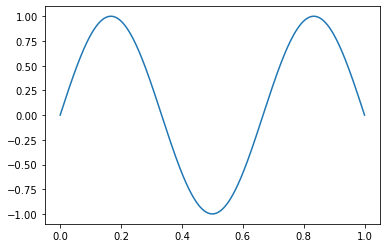

In [21]:
def trial(x):
#     return np.exp(-(x-0.5)**2/0.05)
    return np.sin(3*x*np.pi)
#     return np.ones(len(x))

xs = np.linspace(0,1,500)
data = trial(xs)
plt.plot(xs, data)

In [22]:
designfit_lstsq(xs,data,design)

array([ 2.11768198e-01,  7.63066941e-01, -5.46550877e-01, -1.42347847e-01,
       -7.03262173e-02,  8.26840993e-17, -6.49920143e-17,  4.24040726e-17,
        4.61815046e-17])

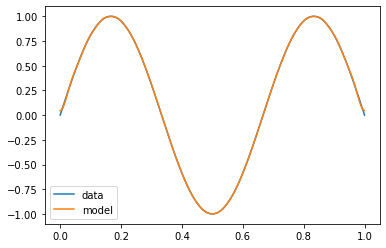

In [26]:
design = fourier_design(xs,20)
parameters = designfit_lstsq(xs,data,design)
plt.plot(xs, data, label='data')
plt.plot(xs, np.matmul(design, parameters), label='model')
plt.legend()
plt.show()

# Outer product; Gaussian x 1

## Sample data

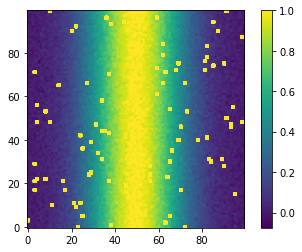

In [9]:
xs = np.linspace(0,1,100)
ys = np.linspace(0,1,100)

def f(y,x):
    xx, yy = np.meshgrid(x, y)
#    return 1*(np.sin(yy))**2*np.exp(-(xx-0.5)**2/0.05)
    return np.exp(-(xx-0.5)**2/0.05)

data_clean = f(ys,xs)
cosmic_rays = 0.5*(1 + np.sign( (1/100) - np.random.rand(len(data_clean),len(data_clean[0]))))
data_sim = data_clean + 0.05*np.random.randn(len(data_clean),len(data_clean[0]))/2 + 1000*cosmic_rays

plt.imshow(data_sim, origin='lower', vmax=1)
plt.colorbar()
plt.show()

## Modelling sample data (iterative lin. alg.)

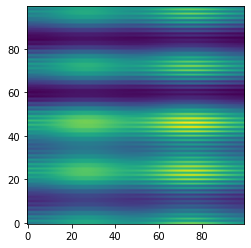

1


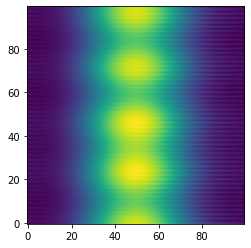

2


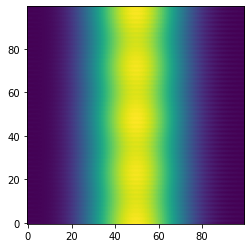

3


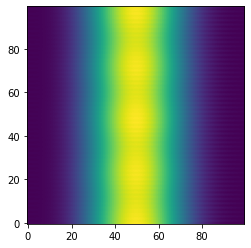

4


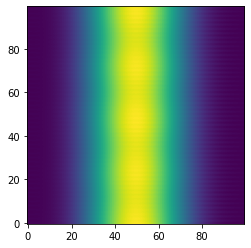

5


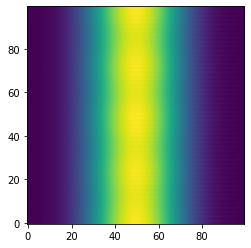

6


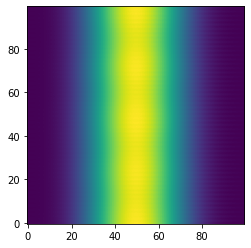

7


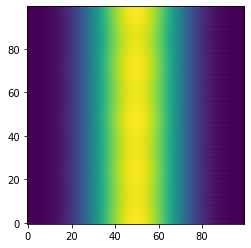

8


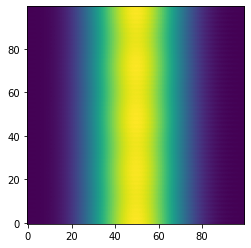

9


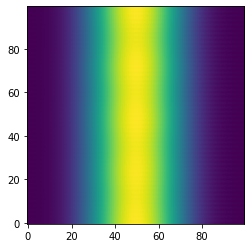

10
Time elapsed is 17.572625875473022. Iterations: 10.


In [55]:
# Constructing grid points
xxs, yys = np.meshgrid(xs,ys)
xxs_flat = xxs.flatten()
yys_flat = yys.flatten()

# Uncomment for Fourier fit
n_freq_x = 5
n_freq_y = 5
x_len = 2*n_freq_x - 1
y_len = 2*n_freq_y - 1
design_x = fourier_design(xxs_flat,n_freq_x)
design_y = fourier_design(yys_flat,n_freq_y)

initial_guess = np.zeros(y_len+x_len)
initial_guess[0] = 1
initial_guess[y_len] = 1

# Uncomment for polynomial fit
# x_len = 11
# y_len = 11
# design_x = np.array([xxs_flat**i for i in range(x_len)]).T
# design_y = np.array([yys_flat**i for i in range(y_len)]).T

# initial_guess = np.ones(y_len+x_len)

guess = minimize_pics(data_sim, design_x, design_y, initial_guess, 10, y_len)

Function in x:


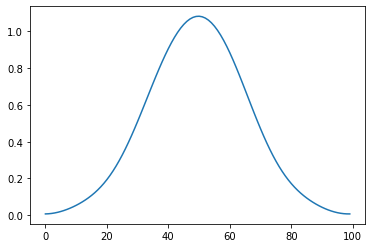

Function in y:


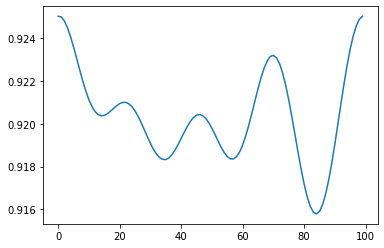

2-D plot


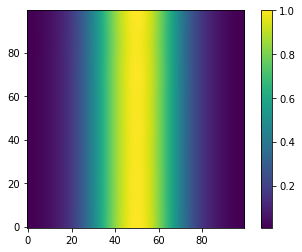

In [11]:
# Uncomment for Fourier fit
design_y_test = fourier_design(ys, n_freq_y)
design_x_test = fourier_design(xs, n_freq_x)

# Uncomment for polynomial fit
# design_y_test = np.array([ys**i for i in range(y_len)]).T
# design_x_test = np.array([xs**i for i in range(x_len)]).T

print('Function in x:')
plt.plot(np.matmul(design_x_test,guess[1]))
plt.show()

print('Function in y:')
plt.plot(np.matmul(design_y_test,guess[0]))
plt.show()

print('2-D plot')
y_hat = np.matmul(design_y_test,guess[0])
x_hat = np.matmul(design_x_test,guess[1])

plt.imshow(np.outer(y_hat,x_hat), origin='lower')
plt.colorbar()
plt.show()

## Using scipy.optimize

In [ ]:
y_len = 4

design_y = np.array([yys_flat**i for i in range(y_len)]).T
design_x = np.array([xxs_flat**i for i in range(11)]).T

design_y_test = np.array([ys**i for i in range(y_len)]).T
design_x_test = np.array([xs**i for i in range(11)]).T

def loss(parameters, data, design_y, design_x, len_y):
    b = parameters[:len_y]
    a = parameters[len_y:]
    y_hat = np.matmul(design_y,b)
    x_hat = np.matmul(design_x,a)
    return np.sum((data - y_hat*x_hat)**2)

initial_guess = np.ones(11+y_len)

start_time = time.time()
guess2 = spop.minimize(loss,initial_guess, (data_sim.flatten(),design_y,design_x,y_len))
print(time.time()-start_time)

In [ ]:
# Model data

b_para = guess2.x[:y_len]
a_para = guess2.x[y_len:]

print('Function in x:')
plt.plot(np.matmul(design_x_test,a_para))
plt.show()

print('Function in y:')
plt.plot(np.matmul(design_y_test,b_para))
plt.show()

print('2-D plot')
y_hat = np.matmul(design_y_test,b_para)
x_hat = np.matmul(design_x_test,a_para)
plt.imshow(np.outer(y_hat,x_hat), origin='lower')
plt.colorbar()

# Outer product; Gaussian x Sine

## Sample data

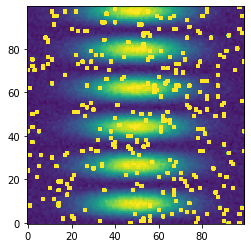

In [12]:
xs = np.linspace(0,1,100)
ys = np.linspace(0,1,100)

def f(y,x):
    xx, yy = np.meshgrid(x, y)
    return 1*(np.sin(2*np.pi*yy/(2.5/7)))**2*np.exp(-(xx-0.5)**2/0.05)

data_clean = f(ys,xs)
cosmic_rays = 0.5*(1 + np.sign( (3/100) - np.random.rand(len(data_clean),len(data_clean[0]))))
data_sim2 = data_clean + 0.05*np.random.randn(len(data_clean),len(data_clean[0]))/2 + 1000*cosmic_rays

plt.imshow(data_sim2, origin='lower', vmax=1)
plt.show()

## Modelling data (iterative lin. alg.)

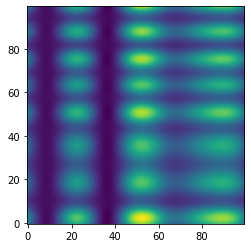

1


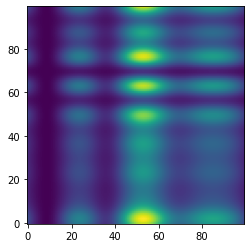

2


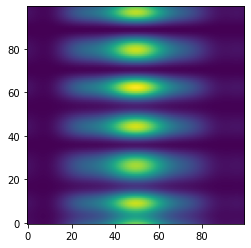

3


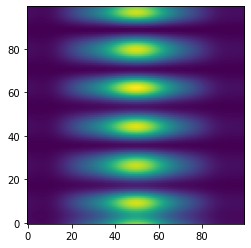

4


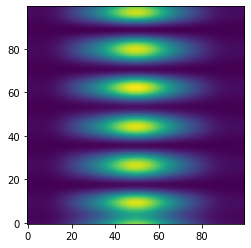

5


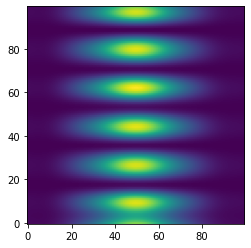

6


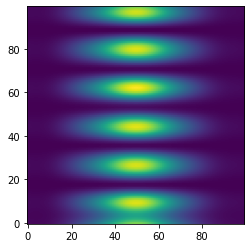

7


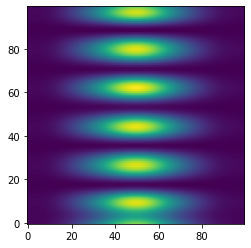

8


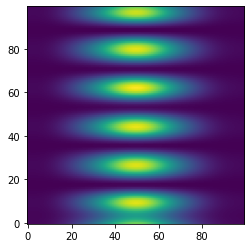

9


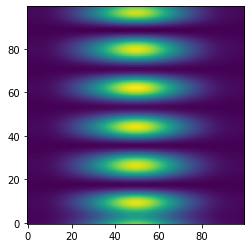

10
Time elapsed is 15.480644226074219. Iterations: 10.


In [14]:
# Constructing grid points
xxs, yys = np.meshgrid(xs,ys)
xxs_flat = xxs.flatten()
yys_flat = yys.flatten()

# Uncomment for Fourier fit
n_freq_x = 5
n_freq_y = 10
x_len = 2*n_freq_x - 1
y_len = 2*n_freq_y - 1
design_x = fourier_design(xxs_flat,n_freq_x)
design_y = fourier_design(yys_flat,n_freq_y)

initial_guess = np.zeros(y_len+x_len)
initial_guess[0] = 1
initial_guess[y_len] = 1

# Uncomment for polynomial fit
# x_len = 11
# y_len = 35
# design_x = np.array([xxs_flat**i for i in range(x_len)]).T
# design_y = np.array([yys_flat**i for i in range(y_len)]).T

initial_guess = np.ones(x_len + y_len)

guess = minimize_pics(data_sim2, design_x, design_y, initial_guess, 10, y_len)

Function in x:


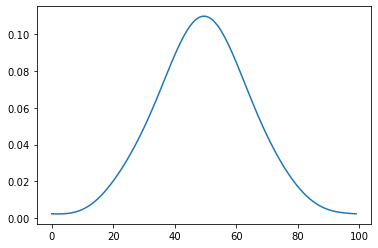

Function in y:


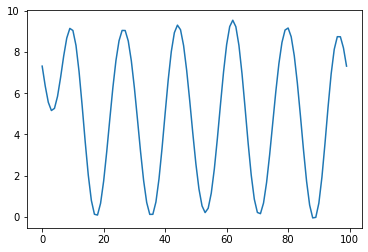

2-D plot


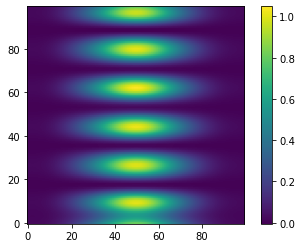

In [15]:
# Uncomment for Fourier fit
design_y_test = fourier_design(ys, n_freq_y)
design_x_test = fourier_design(xs, n_freq_x)

# Uncomment for polynomial fit
# design_y_test = np.array([ys**i for i in range(y_len)]).T
# design_x_test = np.array([xs**i for i in range(x_len)]).T

print('Function in x:')
plt.plot(np.matmul(design_x_test,guess[1]))
plt.show()

print('Function in y:')
plt.plot(np.matmul(design_y_test,guess[0]))
plt.show()

print('2-D plot')
y_hat = np.matmul(design_y_test,guess[0])
x_hat = np.matmul(design_x_test,guess[1])

plt.imshow(np.outer(y_hat,x_hat), origin='lower')
plt.colorbar()
plt.show()

## Using scipy

In [ ]:
y_len = 35
x_len = 35

design_y = np.array([yys_flat**i for i in range(y_len)]).T
design_x = np.array([xxs_flat**i for i in range(x_len)]).T

design_y_test = np.array([ys**i for i in range(y_len)]).T
design_x_test = np.array([xs**i for i in range(x_len)]).T

def loss(parameters, data, design_y, design_x, len_y):
    b = parameters[:len_y]
    a = parameters[len_y:]
    y_hat = np.matmul(design_y,b)
    x_hat = np.matmul(design_x,a)
    return np.sum((data - y_hat*x_hat)**2)

initial_guess = np.ones(x_len+y_len)

start_time = time.time()
guess2 = spop.minimize(loss,initial_guess, (data_sim2.flatten(),design_y,design_x,y_len))
print(time.time()-start_time)

In [ ]:
# Model data

b_para = guess2.x[:y_len]
a_para = guess2.x[y_len:]

print('Function in x:')
plt.plot(np.matmul(design_x_test,a_para))
plt.show()

print('Function in y:')
plt.plot(np.matmul(design_y_test,b_para))
plt.show()

print('2-D plot')
y_hat = np.matmul(design_y_test,b_para)
x_hat = np.matmul(design_x_test,a_para)
plt.imshow(np.outer(y_hat,x_hat), origin='lower')
plt.colorbar()
plt.show()

# APOGEE data

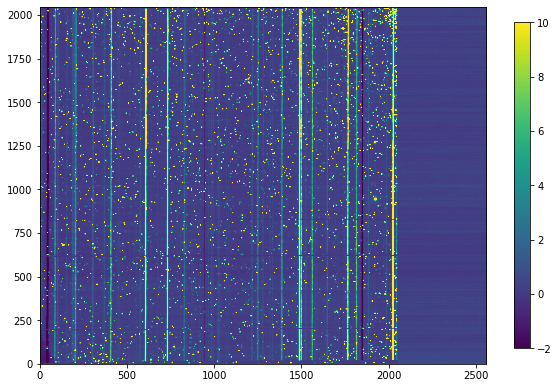

In [37]:
from astropy.io import fits

UNe_arc = fits.open("apR-a-27310005.fits")
data_actualx = UNe_arc[0].data

plt.figure(figsize=(10,10))
plt.imshow(data_actualx, vmin=-2, vmax=10, origin='lower')
plt.colorbar(shrink=0.6)
# plt.xlim(1000,1500)
# plt.ylim(650,750)
plt.show()

## Calibration lines list

In [38]:
xpix_chipnum1 = [11.83,
47.65,
90.78,
156.45,
192.24,
200.55,
208.09,
372.78,
410.50,
445.72,
455.44,
559.02,
577.59,
584.76,
679.23,
733.55,
792.02,
825.20,
830.95,
872.14,
881.42,
895.53,
916.37,
918.46,
940.72,
944.20,
953.51,
968.75,
978.77,
984.15,
994.98,
1017.72,
1026.76,
1041.71,
1065.25,
1069.92,
1082.56,
1161.79,
1216.08,
1246.64,
1250.39,
1278.98,
1318.63,
1333.56,
1387.15,
1469.38,
1472.84,
1487.79,
1497.39,
1523.94,
1560.58,
1576.59,
1590.31,
1600.67,
1617.12,
1646.11,
1659.44,
1709.20,
1729.53,
1764.00,
1806.14,
1813.60,
1816.92,
1830.73,
1846.41,
1863.79,
1880.54,
1894.51,
1921.42,
1977.04,
1985.48,
2022.38,
2032.44]

## Smaller section

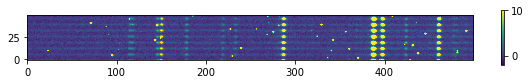

In [151]:
west_end = 1100
east_end = 1600
apogee_span = east_end - west_end

data_actual = UNe_arc[0].data[1650:1700,west_end:east_end]
plt.figure(figsize=(10,10))
plt.imshow(data_actual, vmin=-2, vmax=10, origin='lower')
plt.colorbar(shrink=0.1)
plt.show()

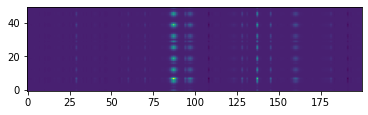

1


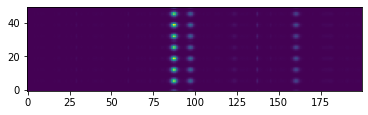

2


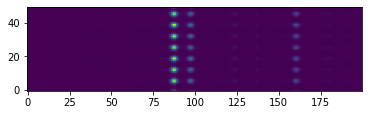

3


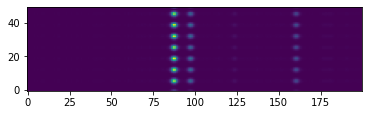

4


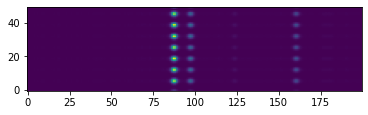

5
Time elapsed is 9.679939031600952. Iterations: 5.


In [139]:
### Fourier ###

# Constructing grid points
xs = np.arange(len(data_actual[0]))
ys = np.arange(len(data_actual[:,0]))

xxs, yys = np.meshgrid(xs,ys)
xxs_flat = xxs.flatten()
yys_flat = yys.flatten()

# Uncomment for Fourier fit
n_freq_x = int(len(data_actual[0])/2)
n_freq_y = int(len(data_actual)/2)
x_len = 2*n_freq_x - 1
y_len = 2*n_freq_y - 1
design_x = fourier_design(xxs_flat,n_freq_x)
design_y = fourier_design(yys_flat,n_freq_y)

initial_guess = np.zeros(y_len+x_len)
initial_guess[0] = 1
initial_guess[y_len] = 1

initial_guess = np.ones(x_len + y_len)

guess = minimize_pics(data_actual, design_x, design_y, initial_guess, 5, y_len)

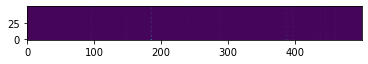

1


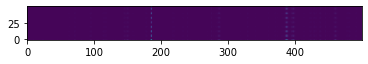

2


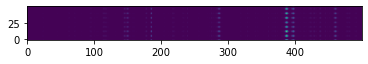

3


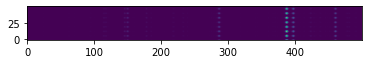

4


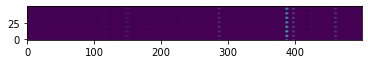

5


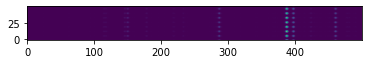

6


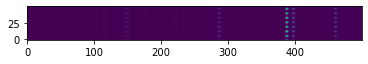

7


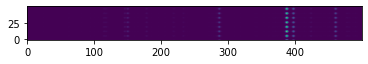

8


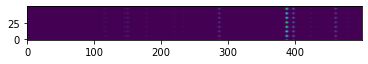

9


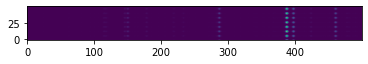

10


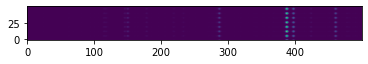

11


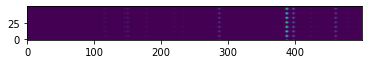

12


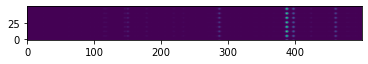

13


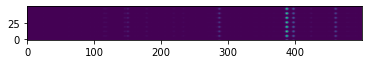

14


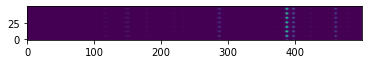

15


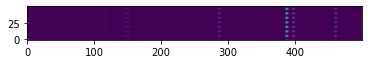

16


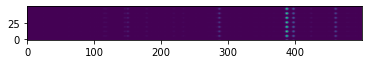

17


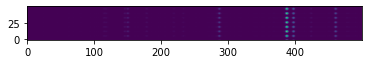

18


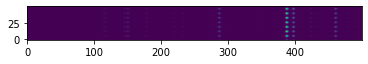

19


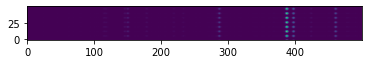

20
Time elapsed is 45.16258096694946. Iterations: 20.


In [194]:
### Fourier ###

# Constructing grid points
xs = np.arange(len(data_actual[0]))
ys = np.arange(len(data_actual[:,0]))

xxs, yys = np.meshgrid(xs,ys)
xxs_flat = xxs.flatten()
yys_flat = yys.flatten()

# Uncomment for Fourier fit
n_freq_x = int(len(data_actual[0])/2)
n_freq_y = int(len(data_actual)/2)
x_len = 2*n_freq_x - 1
y_len = 2*n_freq_y - 1
design_x = fourier_design(xxs_flat,n_freq_x)
design_y = fourier_design(yys_flat,n_freq_y)

initial_guess = np.zeros(y_len+x_len)
initial_guess[0] = 1
initial_guess[y_len] = 1

initial_guess = np.ones(x_len + y_len)

guess = minimize_pics_lstsq(data_actual, design_x, design_y, initial_guess, 20, y_len)

In [ ]:
40.02124905586243

In [176]:
### PTP minimization ###
initial_guess = np.ones(len(data_actual) + len(data_actual[0]))
y_model, x_model = minimize_ptp(data_actual, initial_guess, 0.0000000001, 20)

Time elapsed is 1.3070127964019775. Iterations: 20.


Function in x:


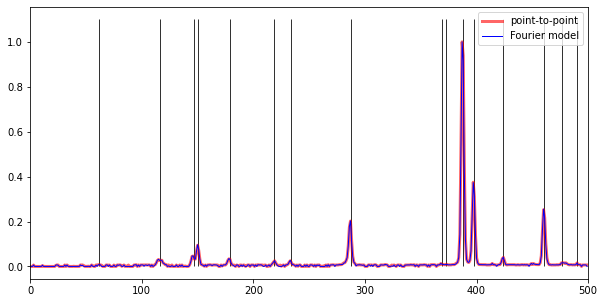

2-D plots:


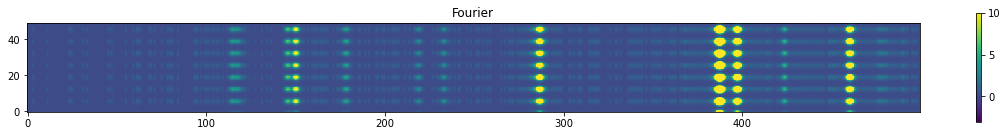

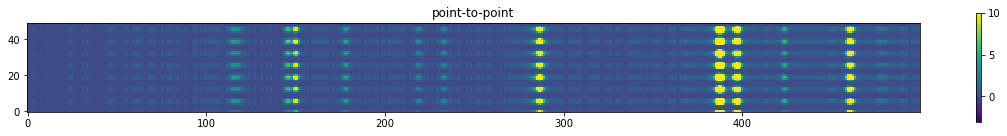

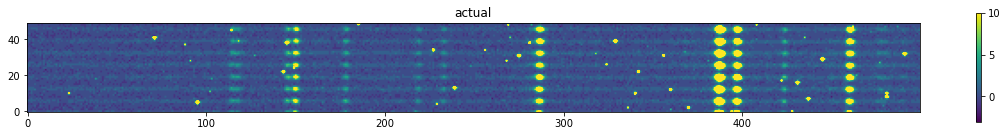

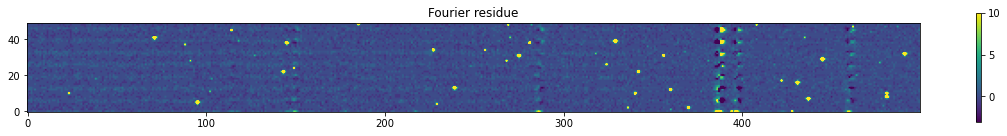

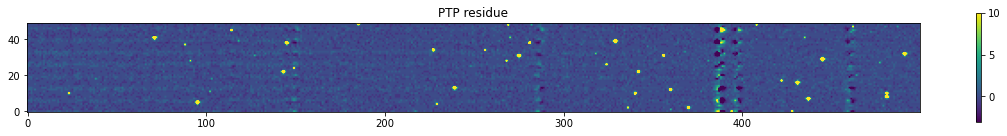

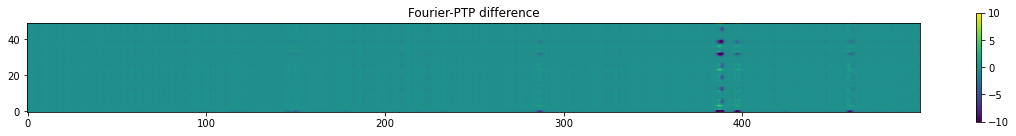

In [195]:
### Results ###

# Uncomment for Fourier fit
design_y_test = fourier_design(ys, n_freq_y)
design_x_test = fourier_design(xs, n_freq_x)

print('Function in x:')
f_x = np.matmul(design_x_test,guess[1])
plt.figure(figsize=(10,5))
plt.plot(x_model/np.max(x_model), label='point-to-point', color='red', lw=3, alpha=0.6)
plt.plot(f_x/np.max(f_x), label='Fourier model', lw=1, color='blue')
plt.vlines(np.array(xpix_chipnum1) - west_end, 0, 1.1, color='black', lw=0.8)
plt.xlim(0,apogee_span)
plt.legend()
plt.savefig('peaks.png')
plt.show()

# print('Function in y:')
# plt.plot(np.matmul(design_y_test,guess[0]))
# plt.show()

print('2-D plots:')
y_hat = np.matmul(design_y_test,guess[0])
x_hat = np.matmul(design_x_test,guess[1])

minv = -3
maxv = 10
minv_res = -3
maxv_res = 10
cbar_shrink = 0.1
sizefig = (20,20)

plt.figure(figsize=sizefig)
data_model_fourier = np.outer(y_hat,x_hat)
plt.imshow(data_model_fourier, vmin=minv, vmax=maxv, origin='lower')
plt.colorbar(shrink=cbar_shrink)
plt.title('Fourier')
plt.savefig('model_fourier.png')
plt.show()

plt.figure(figsize=sizefig)
data_model_ptp = np.outer(y_model,x_model)
plt.imshow(data_model_ptp, origin='lower', interpolation='none', vmin=minv, vmax=maxv)
plt.colorbar(shrink=cbar_shrink)
plt.title('point-to-point')
plt.savefig('model_ptp.png')
plt.show()

plt.figure(figsize=sizefig)
plt.imshow(data_actual, vmin=minv, vmax=maxv, origin='lower')
plt.colorbar(shrink=cbar_shrink)
plt.title('actual')
plt.savefig('actual.png')
plt.show()

plt.figure(figsize=sizefig)
plt.imshow(data_actual - data_model_fourier, vmax=maxv_res, vmin=minv_res, origin='lower')
plt.colorbar(shrink=cbar_shrink)
plt.title('Fourier residue')
plt.savefig('res_fourier.png')
plt.show()

plt.figure(figsize=sizefig)
plt.imshow(data_actual - data_model_ptp, vmax=maxv_res, vmin=minv_res, origin='lower')
plt.colorbar(shrink=cbar_shrink)
plt.title('PTP residue')
plt.savefig('res_ptp.png')
plt.show()

plt.figure(figsize=sizefig)
plt.imshow(data_model_fourier - data_model_ptp, vmax=10, vmin=-10, origin='lower')
plt.colorbar(shrink=cbar_shrink)
plt.title('Fourier-PTP difference')
plt.savefig('dif_fourier_ptp.png')
plt.show()

# Sketch

In [174]:
def remove_zeros_median(array):
    array = np.array(array).astype(float)
    shape = np.shape(array)
    flattened = array.flatten()
    
    flattened[np.argwhere(flattened == 0)] = np.median(array)
#     flattened[np.argwhere(flattened == np.inf)] = 0.0001
    
    return flattened.reshape(shape)

def minimize_pics_lstsq(data, P, Q, init_guess, n_it, len_y):
    'P is the design function in x, and \
     Q is the design function in y.'

    start_time = time.time()
    
    # Defining constants
    N = len(data)*len(data[0])
    z = data.flatten()
    
    # Initializing arrays and values
    y = np.zeros(len(init_guess[:len_y]))
    x = np.zeros(len(init_guess[len_y:]))
    y[:] = init_guess[:len_y]
    x[:] = init_guess[len_y:]
    weight = np.ones_like(data.flatten())
    
    counter = 0
    lsq = 1
    
    while counter < n_it or counter == 1:        
        counter += 1
        sqrt_weight = np.sqrt(weight)
        
        # Solving f(x) parameters
        bQ = np.matmul(y,Q.T)
        M = np.copy(P)
        for i in range(len(M)):
            M[i] = (bQ*sqrt_weight)[i]*M[i]
        x[:] = np.linalg.lstsq(M,z*sqrt_weight,rcond=None)[0][:]
        
        # Solving g(y) parameters
        aP = np.matmul(x,P.T)
        M = np.copy(Q)
        for i in range(len(M)):
            M[i] = (aP*sqrt_weight)[i]*M[i]
        y[:] = np.linalg.lstsq(M,z*sqrt_weight,rcond=None)[0][:]
        
        # Updating squared error matrix; removing zeroes
        y_hat = np.matmul(design_y,y)
        x_hat = np.matmul(design_x,x)
        model = y_hat*x_hat
        weight = 1/remove_zeros_median(np.abs(z - model.flatten())**1)
        
        plt.imshow(model.reshape(np.shape(data)), origin='lower')
        plt.show()
        
        print(counter)

    print(f'Time elapsed is {time.time()-start_time}. Iterations: {counter}.')
    return y,x  

## Minimizer built from one-iteration function

In [191]:
def remove_zeros_median(array):
    array = np.array(array).astype(float)
    shape = np.shape(array)
    flattened = array.flatten()
    
    flattened[np.argwhere(flattened == 0)] = np.median(array)
#     flattened[np.argwhere(flattened == np.inf)] = 0.0001
    
    return flattened.reshape(shape)

def minimize_lstsq_1step(z, P, Q, init_guess, weight, len_y):
    'P is the design function in x, and \
     Q is the design function in y.'

    start_time = time.time()
    
    # Defining constants
    N = len(z)
    
    # Initializing arrays and values
    y = np.zeros(len(init_guess[:len_y]))
    x = np.zeros(len(init_guess[len_y:]))
    y[:] = init_guess[:len_y]
    x[:] = init_guess[len_y:]
    
    # Square root of weights
    sqrt_weight = np.sqrt(weight)
        
    # Solving f(x) parameters
    bQ = np.matmul(y,Q.T)
    M = np.copy(P)
    for i in range(len(M)):
        M[i] = (bQ*sqrt_weight)[i]*M[i]
    x[:] = np.linalg.lstsq(M,z*sqrt_weight,rcond=None)[0][:]

    # Solving g(y) parameters
    aP = np.matmul(x,P.T)
    M = np.copy(Q)
    for i in range(len(M)):
        M[i] = (aP*sqrt_weight)[i]*M[i]
    y[:] = np.linalg.lstsq(M,z*sqrt_weight,rcond=None)[0][:]

    # Updating squared error matrix; removing zeroes
    y_hat = np.matmul(design_y,y)
    x_hat = np.matmul(design_x,x)
    model = y_hat*x_hat
    abs_error = np.abs(z - model.flatten())
        
    print(f'Time elapsed is {time.time()-start_time}.')
    return np.concatenate(y,x), model, abs_error

def minimize_lstsq_2(data, P, Q, init_guess, n_it, len_y):
    'P is the design function in x, and \
     Q is the design function in y.'

    start_time = time.time()
    
    # Defining constants
    N = len(data)*len(data[0])
    data_flat = data.flatten()
    
    # Initializing arrays and values
    output_para = np.copy(init_guess) 
    weight = np.ones_like(data.flatten())
    
    counter = 0
    
    while counter < n_it or counter == 1:        
        counter += 1
        output_para, model, error = minimize_lstsq_1step(data_flat, P, Q, output_para, weight, len_y)
        weight = 1/remove_zeroes_median(error)
    
    print(counter)                 
    plt.imshow(model.reshape(np.shape(data)), origin='lower')
    plt.show()
                     
    return output_para 

In [172]:
test = np.array([1,0,0,0,1,1])

In [173]:
test[np.argwhere(test == 1)] = 69
test

array([69,  0,  0,  0, 69, 69])